## Ejercicio Práctico - Clase 3 VPC2 - 4Co2021

1) Realizar transfer learning a partir de alguna de las siguientes redes: vgg11, resnet18, convnext_tiny preentrenadas, y entrenar sobre el dataset CIFAR10 contenido en PyTorch. Que puede concluir al compararlos con los resultados obtenidos en el entrenamiento de la tarea 2?

2) Realice el entrenamiento de la misma red seleccionada en el punto 1, sin partir de pesos preentrenados en esta oportunidad y sin congelar capas. A que resultados llega y como los explica?


In [ ]:
# Instalamos e importamos librerías de python
import numpy as np
import matplotlib.pyplot as plt

import torch
import tensorflow as tf
import torch.nn.functional as F
import torchvision
import torchsummary
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
!pip install torchmetrics
import torchmetrics

Files already downloaded and verified
Tamaño del conjunto de entrenamiento: 40000
Tamaño del conjunto de validación: 10000
Files already downloaded and verified


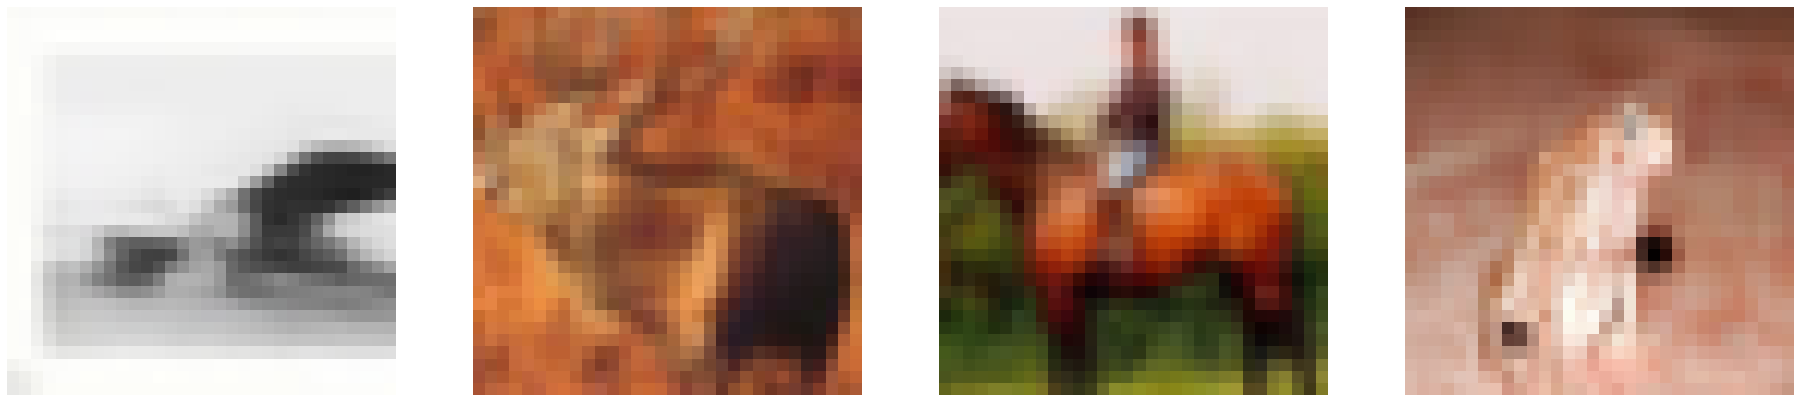

In [ ]:
# Cargamos el dataset SIFAR10 con las transformaciones definidas en el TP de la clase 2

# Aplicamos Data Augmentation
data_transforms = torchvision.transforms.Compose([
                        
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(32, 32), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor(),
                      ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)

# Creamos un conjunto de validación a partir del conjunto de entrenamiento
valid_set_size = 10000
train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])
print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

# Definimos el dataset de test sin las transformaciones
data_transforms_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms_test)

# Visualizamos el resultado: 
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(32, 32))
for id, row in enumerate(rows):
    row.imshow(train_set[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()



In [ ]:
# Cargamos el modelo base ResNet18 con sus pesos

resnet_model = torchvision.models.resnet18(pretrained=True)

resnet_model.to("cuda")

torchsummary.summary(resnet_model, input_size=(3, 32, 32))
resnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
# Congelamos las capas del modelo

for param in resnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Seleccionamos la última capa, la modificamos y por defecto es una capa entrenable con una salida de 10 (porque el dataset CIFAR10 tiene 10 clases)

last_layer_in_features = resnet_model.fc.in_features
resnet_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)
resnet_model.to("cuda")

torchsummary.summary(resnet_model, input_size=(3, 32, 32))
resnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
# Confirmamos cuales son los parametros entrenables del modelo
for name, param in resnet_model.named_parameters(): 
  if param.requires_grad: 
    print (name, param.data)

fc.weight tensor([[ 0.0005, -0.0258,  0.0082,  ..., -0.0260,  0.0127,  0.0102],
        [ 0.0205,  0.0238, -0.0251,  ...,  0.0306,  0.0099, -0.0300],
        [-0.0005,  0.0106,  0.0143,  ...,  0.0143, -0.0092, -0.0263],
        ...,
        [ 0.0305, -0.0325,  0.0024,  ..., -0.0401,  0.0112, -0.0025],
        [-0.0312, -0.0212, -0.0061,  ..., -0.0106,  0.0231,  0.0330],
        [-0.0289, -0.0289,  0.0267,  ...,  0.0094,  0.0276,  0.0230]],
       device='cuda:0')
fc.bias tensor([-0.0036, -0.0133, -0.0036, -0.0182,  0.0222,  0.0374, -0.0191, -0.0315,
         0.0433, -0.0250], device='cuda:0')


In [ ]:
# Definimos el learning rate, optimizador y función de error del modelo
learning_rate= 0.0002
optimizer_ft = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# Definimos la función de entrenamiento del modelo

def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [ ]:
# Entrenamos el modelo
result_model, history = train(resnet_model, criterion, optimizer_ft, train_loader, valid_loader, 20)

Epoch: 1/20 - Train loss 1.949946 - Train Accuracy 0.308400 - Valid Loss 1.765475 - Valid Accuracy 0.391873
Epoch: 2/20 - Train loss 1.743827 - Train Accuracy 0.386500 - Valid Loss 1.695526 - Valid Accuracy 0.422224
Epoch: 3/20 - Train loss 1.698096 - Train Accuracy 0.403775 - Valid Loss 1.652143 - Valid Accuracy 0.430811
Epoch: 4/20 - Train loss 1.677026 - Train Accuracy 0.412350 - Valid Loss 1.658083 - Valid Accuracy 0.429712
Epoch: 5/20 - Train loss 1.658954 - Train Accuracy 0.419325 - Valid Loss 1.653042 - Valid Accuracy 0.432408
Epoch: 6/20 - Train loss 1.661754 - Train Accuracy 0.417200 - Valid Loss 1.644137 - Valid Accuracy 0.434006
Epoch: 7/20 - Train loss 1.656553 - Train Accuracy 0.419700 - Valid Loss 1.636118 - Valid Accuracy 0.440595
Epoch: 8/20 - Train loss 1.648925 - Train Accuracy 0.421800 - Valid Loss 1.625950 - Valid Accuracy 0.438299
Epoch: 9/20 - Train loss 1.644672 - Train Accuracy 0.420750 - Valid Loss 1.635155 - Valid Accuracy 0.429912
Epoch: 10/20 - Train loss 1.

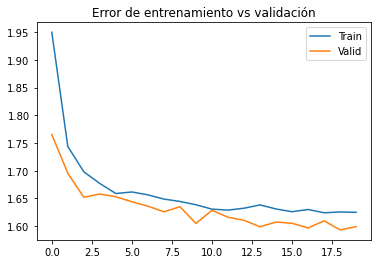

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
# Cargamos el modelo base ResNet18 sin pesos

resnet_scratch = torchvision.models.resnet18(pretrained=False)
resnet_scratch.to("cuda")

# Seleccionamos la última capa, la modificamos y por defecto es una capa entrenable con una salida de 10 (porque el dataset CIFAR10 tiene 10 clases)

last_layer_in_features = resnet_scratch.fc.in_features
resnet_scratch.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

# Definimos el learning rate, optimizador y función de error del modelo
learning_rate= 0.0002
optimizer_ft = torch.optim.Adam(resnet_scratch.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Entrenamos el modelo desde cero, sin parametros pre-entrenados

result_model2, history2 = train(resnet_scratch, criterion, optimizer_ft, train_loader, valid_loader, 20)

Epoch: 1/20 - Train loss 1.673363 - Train Accuracy 0.388975 - Valid Loss 1.461792 - Valid Accuracy 0.472344
Epoch: 2/20 - Train loss 1.392431 - Train Accuracy 0.499175 - Valid Loss 1.375027 - Valid Accuracy 0.508886
Epoch: 3/20 - Train loss 1.241890 - Train Accuracy 0.560550 - Valid Loss 1.240387 - Valid Accuracy 0.557608
Epoch: 4/20 - Train loss 1.147553 - Train Accuracy 0.593775 - Valid Loss 1.239421 - Valid Accuracy 0.570288
Epoch: 5/20 - Train loss 1.071277 - Train Accuracy 0.623975 - Valid Loss 1.483286 - Valid Accuracy 0.509185
Epoch: 6/20 - Train loss 1.023186 - Train Accuracy 0.641375 - Valid Loss 1.026379 - Valid Accuracy 0.634884
Epoch: 7/20 - Train loss 0.964604 - Train Accuracy 0.662475 - Valid Loss 1.090772 - Valid Accuracy 0.619908
Epoch: 8/20 - Train loss 0.922438 - Train Accuracy 0.678850 - Valid Loss 1.050258 - Valid Accuracy 0.631190
Epoch: 9/20 - Train loss 0.883643 - Train Accuracy 0.692325 - Valid Loss 0.968560 - Valid Accuracy 0.660942
Epoch: 10/20 - Train loss 0.

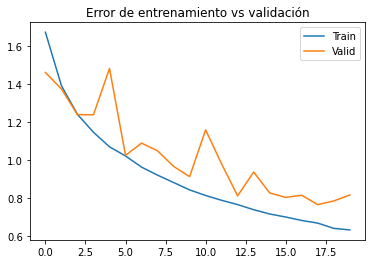

In [ ]:
plt.plot(history2["train_loss"])
plt.plot(history2["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()